# **Introduction**
In the previous parts of the project I created models based on 204 bands in order to classify the different plants on the green wall.

Hyperspectral cameras are very expensive and therefore currently not used as an acceptable tool for real-time continuous monitoring. The main goal of the project is to produce a model that enables real-time monitoring of the development of green walls in order to facilitate their maintenance (which is the main obstacle that prevents their integration in internal and external spaces.

In this part, I will try to **produce a model based on only 4 bands**: red, green, blue and NIR (*RGBN*). Cameras based on these bands are very common and are used for monitoring and security purposes, so such a successful model can be very useful and practical for monitoring

###**Stages**:
  1. Create dataset of 4 features.

  2. Build the models and evaluate.

  3. Apply on images.

## 1. **Create dataset of 4 features (RGBN)**

Import the packeges

In [1]:
import glob #files arrangments and import from folders
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
palette =["deeppink","lime","Orange","red","forestgreen","cyan"]
sns.set_theme(style="white",font_scale = 1.5, palette=palette)
# Set the font to Times new roman
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
import sklearn.metrics as metrics
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
!pip install torchinfo
from torchinfo import summary
from tqdm.notebook import tqdm
from sklearn.metrics import f1_score
!pip install spectral
import spectral.io.envi as envi
from pathlib import Path
from spectral import *
import matplotlib.pyplot as plt
import skimage.io as io
from skimage import transform
import skimage

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 212 kB 10.3 MB/s 


Import the data and keep the RGBN bands.

**Red** =  680 nm

**Green** = 550 nm

**Blue** = 414 nm 

**NIR** = band 732 nm (Based on feature importance in part 1)

In [2]:
df = pd.read_csv("/content/drive/MyDrive/Greenwall/Hyperspectral_data/All_data/All_data_clean.csv", index_col="Unnamed: 0")
df

,Species,414.63,417.52,420.4,423.29,426.19,429.08,431.97,434.87,437.76,...,908.24,911.3,914.36,917.42,920.48,923.55,926.61,929.68,932.74,935.81
1,Tradescantia,0.074322,0.070541,0.066106,0.061432,0.056805,0.052832,0.052405,0.048077,0.047156,...,0.690270,0.695215,0.689560,0.683761,0.683432,0.686154,0.676282,0.657895,0.653666,0.654989
2,Tradescantia,0.081754,0.080618,0.072115,0.066773,0.063905,0.065511,0.061763,0.056366,0.054524,...,0.695364,0.692572,0.692308,0.692308,0.686391,0.689231,0.666667,0.664642,0.668111,0.647372
3,Tradescantia,0.078038,0.070541,0.072115,0.064103,0.059172,0.059172,0.052405,0.051393,0.047156,...,0.685176,0.684642,0.684066,0.686610,0.683432,0.670769,0.676282,0.661269,0.660888,0.643564
4,Tradescantia,0.074322,0.073900,0.069111,0.064103,0.061539,0.059172,0.054277,0.051393,0.047156,...,0.672440,0.674068,0.673077,0.666667,0.659763,0.664615,0.653846,0.651147,0.646443,0.639756
5,Tradescantia,0.074322,0.066890,0.066106,0.063881,0.059172,0.054795,0.054277,0.048077,0.047156,...,0.672119,0.671425,0.678246,0.666667,0.674191,0.664195,0.670284,0.657895,0.642831,0.643564
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10772,Peperomia,0.055453,0.053030,0.049959,0.046173,0.046880,0.044288,0.046016,0.043210,0.042294,...,0.630259,0.639446,0.636262,0.632090,0.633376,0.621910,0.615714,0.606804,0.601310,0.580253
10773,Peperomia,0.047752,0.045770,0.040741,0.043457,0.037504,0.030125,0.034154,0.028855,0.030253,...,0.598889,0.600961,0.603197,0.597935,0.601201,0.594422,0.587076,0.572883,0.562337,0.563311
10774,Peperomia,0.051492,0.052812,0.047009,0.043457,0.039848,0.036235,0.034086,0.033128,0.029002,...,0.601741,0.603922,0.602286,0.603358,0.586951,0.584114,0.579916,0.572883,0.550287,0.540575
10775,Peperomia,0.063375,0.059854,0.062449,0.054494,0.053912,0.050327,0.044312,0.043210,0.037461,...,0.499074,0.494387,0.484918,0.482048,0.488889,0.487907,0.476104,0.471121,0.461920,0.448955


In [3]:
wavelength = df.columns
bands = np.arange(0,len(wavelength),1)

# convert bands to wavelengh
bands_to_wl = dict(zip(bands, wavelength))
# convert wavelengh to bands:
wl_to_bands = dict(zip(wavelength, bands))

In [4]:
df = df[['Species', '414.63','551.49','681.69','732.53']]

 ## **2. Build the models and evaluate**.

### PCA

In order to choose the best RGBN bands lets check the data:

In [5]:
# Apply Standardization (without the first column of the species):
z = df[df.columns[1:]].apply(lambda x:(x-x.mean())/x.std(), axis=0) 
# Apply PCA
pca = PCA().fit(z)
# Transformation
X_trans = pca.transform(z)

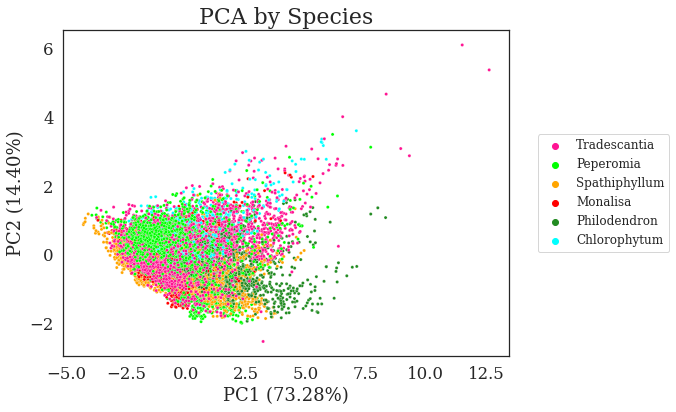

In [6]:
color_var = 'Species'
colors = df[color_var] #colors by species

fig, ax = plt.subplots(1, figsize=(8,6))
ax = sns.scatterplot(x=X_trans[:,0], y=X_trans[:,1],s=10, hue=colors)
ax.set_xlabel('PC1 ({:.2f}%)'.format(100*pca.explained_variance_ratio_[0]))
ax.set_ylabel('PC2 ({:.2f}%)'.format(100*pca.explained_variance_ratio_[1]))
ax.set_title("PCA by Species",fontsize=22)
plt.legend(loc=6, bbox_to_anchor=(1.05, 0.5),fontsize=12)

Look like we have clusters by the species

### **Logistic Regression**

1. **Define features and labels** and shuffle the data.

2. **Split the data** into train, validation, and test (70%, 15%, 15% respectively).
3. Standardization.

3. train the model and tune the hyperparameters.

4. evalute on test set and confusion matrix

5. Save the model.

In [5]:
# Define features and labels:
df = df.sample(frac=1) # Shuffle the data 
X = df.drop('Species', axis='columns') #All column except of the Species column
X = (X-X.mean())/X.std() #standardization
Y = df.Species

In [6]:
# Split the data into train , validation, and test
train_ratio = 0.7
test_ratio = 0.3
val_ratio =0.5 # 0.5 of 30% = 15%
# train is now 70% of the entire data set
# the _junk suffix means that we drop that variable completely
x_train, x_test, y_train, y_test = train_test_split(X,
                                                    Y,
                                                    test_size=1 - train_ratio)
# Split to validation and test:
x_val, x_test, y_val, y_test = train_test_split(x_test,
                                                    y_test,
                                                    test_size=val_ratio) 

print("x train length: ",len(x_train),
      "\n","x validation length: ", len(x_val),
      "\n","x test length: ", len(x_test))

x train length:  7536 
 x validation length:  1615 
 x test length:  1615


In [7]:
# define the model for multiclass classification:
logreg = LogisticRegression(multi_class='multinomial',solver='lbfgs')
# Fit the model on the train set:
logreg.fit(x_train,y_train)

# -------- Validation-----------------#
y_val_pred = logreg.predict(x_val)

print("Validation: Accuracy:",metrics.accuracy_score(y_val, y_val_pred))
print("Validation: Precision:",metrics.precision_score(y_val, y_val_pred,average='weighted'))
print("Validation: Recall:",metrics.recall_score(y_val, y_val_pred,average='weighted'))
print("Validation: f1:",metrics.f1_score(y_val, y_val_pred,average='weighted'))

Validation: Accuracy: 0.5585139318885449
Validation: Precision: 0.5634307518261369
Validation: Recall: 0.5585139318885449
Validation: f1: 0.5588558495518261


In [8]:
# -------- Test-----------------#
y_test_pred = logreg.predict(x_test)

print("Test: Accuracy:",metrics.accuracy_score(y_test, y_test_pred))
print("Test: Precision:",metrics.precision_score(y_test, y_test_pred,average='weighted'))
print("Test: Recall:",metrics.recall_score(y_test, y_test_pred,average='weighted'))
print("Test: f1:",metrics.f1_score(y_test, y_test_pred,average='weighted'))

Test: Accuracy: 0.5684210526315789
Test: Precision: 0.5782003041758843
Test: Recall: 0.5684210526315789
Test: f1: 0.5704396436587973


Text(0.5, 1.0, 'Logistic Regression RGBN')

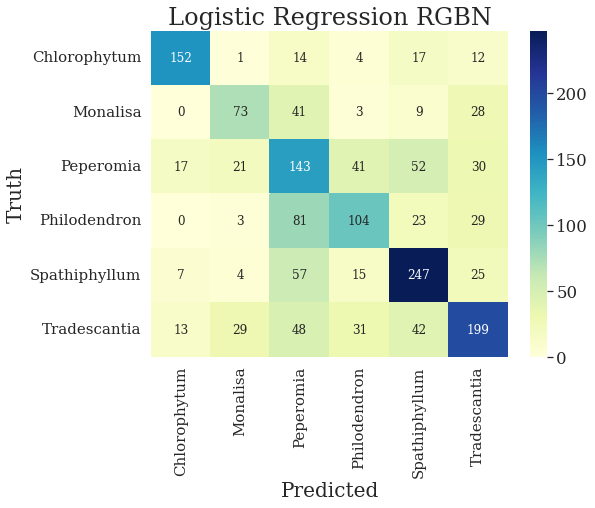

In [9]:
# labels to confiusion matrix:
unique_label = np.unique([y_test, y_test_pred])
# le.inverse_transform(np.unique(y_test_pred)),le.inverse_transform(np.unique(y_test))
# df of confiusion matrix:
cmtx = pd.DataFrame(
    confusion_matrix(y_test, y_test_pred, labels=unique_label), 
    index=[x for x in unique_label], 
    columns=[x for x in unique_label])
plt.figure(figsize = (8,6))
sns.heatmap(cmtx, annot=True, fmt='d',annot_kws={"size": 12},cmap="YlGnBu")
plt.xlabel('Predicted',fontsize = 20)
plt.ylabel('Truth', fontsize = 20)
plt.xticks(fontsize =15,rotation=90)
plt.yticks(fontsize =15,rotation=0)
plt.title('Logistic Regression RGBN', fontsize = 24)

In [10]:
f1 = f1_score(y_test, y_test_pred, average=None) #f1 score to each label
# df with f1 score
df_score =pd.DataFrame(index = np.unique([y_val])) 
df_score['F1_Log_reg'] = f1
df_score

,F1_Log_reg
Chlorophytum,0.781491
Monalisa,0.512281
Peperomia,0.415698
Philodendron,0.474886
Spathiphyllum,0.663087
Tradescantia,0.581022


Save:

In [83]:
# import pickle
# with open("/content/drive/MyDrive/Greenwall/Hyperspectral_data/All_data/Models/RGBN_Logistic_Reg", "wb") as f:
#   pickle.dump(logreg,f)

### **Random Forest**

1. **Define features and labels** and shuffle the data.

2. **Split the data** into train, validation, and test (70%, 15%, 15% respectively).

3. train the model and tune the hyperparameters.

4. evalute on test set and confusion matrix.

5. Perform "**Feature Importence**" to check which band is more affect on the results.

In [11]:
X = df.drop('Species', axis='columns') #All column except of the Species column
Y = df.Species

In [12]:
# Split the data into train , validation, and test
train_ratio = 0.7
test_ratio = 0.3
val_ratio =0.5 # 0.5 of 30% = 15%
# train is now 70% of the entire data set
# the _junk suffix means that we drop that variable completely
x_train, x_test, y_train, y_test = train_test_split(X,
                                                    Y,
                                                    test_size=1 - train_ratio)
# Split to validation and test:
x_val, x_test, y_val, y_test = train_test_split(x_test,
                                                    y_test,
                                                    test_size=val_ratio) 

print("x train length: ",len(x_train),
      "\n","x validation length: ", len(x_val),
      "\n","x test length: ", len(x_test))

x train length:  7536 
 x validation length:  1615 
 x test length:  1615


In [13]:
# define the model for multiclass classification:
clf = RandomForestClassifier() # Set the arguments of the classifier

# -------- train-----------------#
clf.fit(x_train, y_train)

y_train_pred = clf.predict(x_train)

print("Training: Accuracy:",metrics.accuracy_score(y_train, y_train_pred))

Training: Accuracy: 0.9997346072186837


In [14]:
# -------- Validation-----------------#
y_val_pred = clf.predict(x_val)

print("Validation: Accuracy:",metrics.accuracy_score(y_val, y_val_pred))
print("Validation: Precision:",metrics.precision_score(y_val, y_val_pred,average='weighted'))
print("Validation: Recall:",metrics.recall_score(y_val, y_val_pred,average='weighted'))
print("Validation: f1:",metrics.f1_score(y_val, y_val_pred,average='weighted'))

Validation: Accuracy: 0.7157894736842105
Validation: Precision: 0.7129492037942992
Validation: Recall: 0.7157894736842105
Validation: f1: 0.7124639869293261


In [15]:
# -------- Test-----------------#
y_test_pred = clf.predict(x_test)

print("Test: Accuracy:",metrics.accuracy_score(y_test, y_test_pred))
print("Test: Precision:",metrics.precision_score(y_test, y_test_pred,average='weighted'))
print("Test: Recall:",metrics.recall_score(y_test, y_test_pred,average='weighted'))
print("Test: f1:",metrics.f1_score(y_test, y_test_pred,average='weighted'))

Test: Accuracy: 0.7256965944272445
Test: Precision: 0.7237825356913233
Test: Recall: 0.7256965944272445
Test: f1: 0.7242226775130881


Text(0.5, 1.0, 'Random Forest')

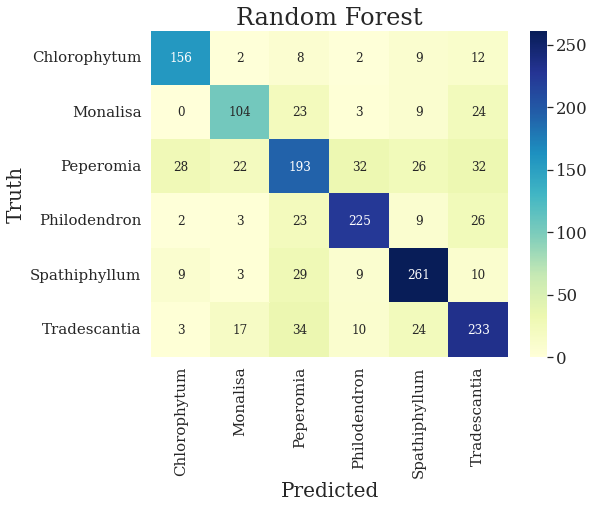

In [16]:
# labels to confiusion matrix:
unique_label = np.unique([y_test, y_test_pred])
# df of confiusion matrix:
cmtx = pd.DataFrame(
    confusion_matrix(y_test, y_test_pred, labels=unique_label), 
    index=[x for x in unique_label], 
    columns=[x for x in unique_label])
plt.figure(figsize = (8,6))
sns.heatmap(cmtx, annot=True, fmt='d',annot_kws={"size": 12},cmap="YlGnBu")
plt.xlabel('Predicted',fontsize = 20)
plt.ylabel('Truth', fontsize = 20)
plt.xticks(fontsize =15,rotation=90)
plt.yticks(fontsize =15,rotation=0)
plt.title('Random Forest', fontsize = 24)

In [17]:
f1 = f1_score(y_test, y_test_pred, average=None) #f1 score to each label 
df_score['F1_Score_RF'] = f1
df_score

,F1_Log_reg,F1_Score_RF
Chlorophytum,0.781491,0.806202
Monalisa,0.512281,0.662420
Peperomia,0.415698,0.600311
Philodendron,0.474886,0.790861
Spathiphyllum,0.663087,0.792109
Tradescantia,0.581022,0.708207


In [18]:
import time
from sklearn.inspection import permutation_importance

start_time = time.time() #time calculation
result = permutation_importance(
    clf, x_test, y_test, n_repeats=10, random_state=42, n_jobs=2
) 
elapsed_time = time.time() - start_time # Final time
print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

forest_importances = pd.DataFrame(result.importances_mean, index=X.columns) #Series of results

Elapsed time to compute the importances: 4.441 seconds


(array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 ]),
 <a list of 9 Text major ticklabel objects>)

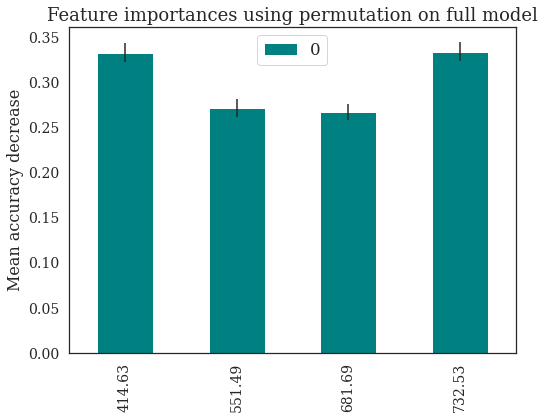

In [19]:
fig, ax = plt.subplots(figsize = (8,6))
forest_importances.plot.bar(yerr=result.importances_std, ax=ax,color = "teal")
ax.set_title("Feature importances using permutation on full model",fontsize = 18)
ax.set_ylabel("Mean accuracy decrease",fontsize = 16)
# We change the fontsize of minor ticks label 
# ax.tick_params(axis='both', which='major', labelsize=20)
plt.xticks(fontsize =14)
plt.yticks(fontsize =14)

Save:

In [62]:
# import pickle
# with open("/content/drive/MyDrive/Greenwall/Hyperspectral_data/All_data/Models/RGBN_RF", "wb") as f:
#   pickle.dump(clf,f)

### **Deep Neural Network**

For more details on the code you can see part 1 of this tutorial

In [20]:
labels_dict = {
    'Tradescantia':0,
    'Peperomia':1,
    'Spathiphyllum':2,
    'Monalisa':3,
    'Philodendron':4,
    'Chlorophytum':5
    }
# If you want to replace keys and values:
# labels_dict = {v: k for k, v in labels_dict.items()}

X = df.drop('Species', axis='columns') #All column except of the Species column
X = (X-X.mean())/X.std() #Normalization 
Y = df['Species'].replace(labels_dict)

Split to train, validation and teat (70-15-15)

In [21]:
# Split the data into train , validation, and test
train_ratio = 0.7
test_ratio = 0.3
val_ratio =0.5 # 0.5 of 30% = 15%
# train is now 70% of the entire data set
# the _junk suffix means that we drop that variable completely
x_train, x_test, y_train, y_test = train_test_split(X,
                                                    Y,
                                                    test_size=1 - train_ratio)
# Split to validation and test:
x_val, x_test, y_val, y_test = train_test_split(x_test,
                                                    y_test,
                                                    test_size=val_ratio) 

print("x train length: ",len(x_train),
      "\n","x validation length: ", len(x_val),
      "\n","x test length: ", len(x_test))

x train length:  7536 
 x validation length:  1615 
 x test length:  1615


In [22]:
X_train, y_train = np.array(x_train), np.array(y_train)
X_val, y_val = np.array(x_val), np.array(y_val)
X_test, y_test = np.array(x_test), np.array(y_test)

In [23]:
class ClassifierDataset(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)


train_dataset = ClassifierDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).long())
val_dataset = ClassifierDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).long())
test_dataset = ClassifierDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).long())

In [91]:
EPOCHS = 23
BATCH_SIZE = 16
LEARNING_RATE = 0.0001
NUM_FEATURES = len(X.columns)
NUM_CLASSES = 6

In [92]:
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE)
val_loader = DataLoader(dataset=val_dataset, batch_size=1)
test_loader = DataLoader(dataset=test_dataset, batch_size=1)

In [93]:
class MulticlassClassification(nn.Module):
    def __init__(self, num_feature, num_class):
        super(MulticlassClassification, self).__init__()
        
        self.layer_1 = nn.Linear(num_feature, 512) #input = num_feature, output=512
        self.layer_2 = nn.Linear(512, 512)
        self.layer_3 = nn.Linear(512, 128)
        self.layer_out = nn.Linear(128, num_class) 
        
        self.relu = nn.ReLU() #Relu activation function
        self.dropout = nn.Dropout(p=0.1) #Dropout for avoid overfit
        self.batchnorm1 = nn.BatchNorm1d(512) # Batch normalization
        self.batchnorm2 = nn.BatchNorm1d(512)
        self.batchnorm3 = nn.BatchNorm1d(128)
        
    def forward(self, x):
        x = self.layer_1(x)
        x = self.batchnorm1(x)
        x = self.relu(x)
        
        x = self.layer_2(x)
        x = self.batchnorm2(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.layer_3(x)
        x = self.batchnorm3(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.layer_out(x)
        
        return x

In [94]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [95]:
model = MulticlassClassification(num_feature = NUM_FEATURES, num_class=NUM_CLASSES)
model.to(device)

Loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
print(model)

MulticlassClassification(
  (layer_1): Linear(in_features=4, out_features=512, bias=True)
  (layer_2): Linear(in_features=512, out_features=512, bias=True)
  (layer_3): Linear(in_features=512, out_features=128, bias=True)
  (layer_out): Linear(in_features=128, out_features=6, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.1, inplace=False)
  (batchnorm1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm3): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [96]:
print(summary(model))

Layer (type:depth-idx)                   Param #
MulticlassClassification                 --
├─Linear: 1-1                            2,560
├─Linear: 1-2                            262,656
├─Linear: 1-3                            65,664
├─Linear: 1-4                            774
├─ReLU: 1-5                              --
├─Dropout: 1-6                           --
├─BatchNorm1d: 1-7                       1,024
├─BatchNorm1d: 1-8                       1,024
├─BatchNorm1d: 1-9                       256
Total params: 333,958
Trainable params: 333,958
Non-trainable params: 0


In [97]:
def multi_acc(y_pred, y_test):
    y_pred_softmax = torch.log_softmax(y_pred, dim = 1)
    _, y_pred_tags = torch.max(y_pred_softmax, dim = 1)    
    
    correct_pred = (y_pred_tags == y_test).float()
    acc = correct_pred.sum() / len(correct_pred)
    
    acc = torch.round(acc * 100)
    
    return acc


accuracy_stats = {
    'train': [],
    "val": []
}
loss_stats = {
    'train': [],
    "val": []
}

In [98]:
print("Begin training.")
for e in tqdm(range(1, EPOCHS+1)):
    
    # TRAINING
    train_epoch_loss = 0
    train_epoch_acc = 0
    model.train()
    for X_train_batch, y_train_batch in train_loader:
        X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)
        optimizer.zero_grad()
        
        y_train_pred = model(X_train_batch)
        
        train_loss = Loss(y_train_pred, y_train_batch)
        train_acc = multi_acc(y_train_pred, y_train_batch)
        
        train_loss.backward()
        optimizer.step()
        
        train_epoch_loss += train_loss.item()
        train_epoch_acc += train_acc.item()
        
        
    # VALIDATION    
    with torch.no_grad():
        
        val_epoch_loss = 0
        val_epoch_acc = 0
        
        model.eval()
        for X_val_batch, y_val_batch in val_loader:
            X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)
            
            y_val_pred = model(X_val_batch)
                        
            val_loss = Loss(y_val_pred, y_val_batch)
            val_acc = multi_acc(y_val_pred, y_val_batch)
            
            val_epoch_loss += val_loss.item()
            val_epoch_acc += val_acc.item()
    loss_stats['train'].append(train_epoch_loss/len(train_loader))
    loss_stats['val'].append(val_epoch_loss/len(val_loader))
    accuracy_stats['train'].append(train_epoch_acc/len(train_loader))
    accuracy_stats['val'].append(val_epoch_acc/len(val_loader))
                              
    
    print(f'Epoch {e+0:02}: | Train Loss: {train_epoch_loss/len(train_loader):.5f} | Val Loss: {val_epoch_loss/len(val_loader):.5f} | Train Acc: {train_epoch_acc/len(train_loader):.3f}| Val Acc: {val_epoch_acc/len(val_loader):.3f}')

Begin training.


  0%|          | 0/23 [00:00<?, ?it/s]

Epoch 01: | Train Loss: 1.22818 | Val Loss: 1.05281 | Train Acc: 53.605| Val Acc: 63.839
Epoch 02: | Train Loss: 1.11637 | Val Loss: 1.01008 | Train Acc: 56.851| Val Acc: 64.025
Epoch 03: | Train Loss: 1.09159 | Val Loss: 0.99493 | Train Acc: 57.690| Val Acc: 63.963
Epoch 04: | Train Loss: 1.07281 | Val Loss: 0.98025 | Train Acc: 57.960| Val Acc: 64.458
Epoch 05: | Train Loss: 1.06000 | Val Loss: 0.97610 | Train Acc: 58.410| Val Acc: 64.334
Epoch 06: | Train Loss: 1.04910 | Val Loss: 0.96618 | Train Acc: 59.011| Val Acc: 65.077
Epoch 07: | Train Loss: 1.03650 | Val Loss: 0.95473 | Train Acc: 59.454| Val Acc: 65.201
Epoch 08: | Train Loss: 1.03077 | Val Loss: 0.95574 | Train Acc: 59.520| Val Acc: 64.954
Epoch 09: | Train Loss: 1.02269 | Val Loss: 0.95971 | Train Acc: 59.465| Val Acc: 65.077
Epoch 10: | Train Loss: 1.01497 | Val Loss: 0.95248 | Train Acc: 60.034| Val Acc: 65.201
Epoch 11: | Train Loss: 1.00879 | Val Loss: 0.94794 | Train Acc: 60.036| Val Acc: 64.892
Epoch 12: | Train Los

Text(0.5, 1.0, 'Train-Val Loss/Epoch')

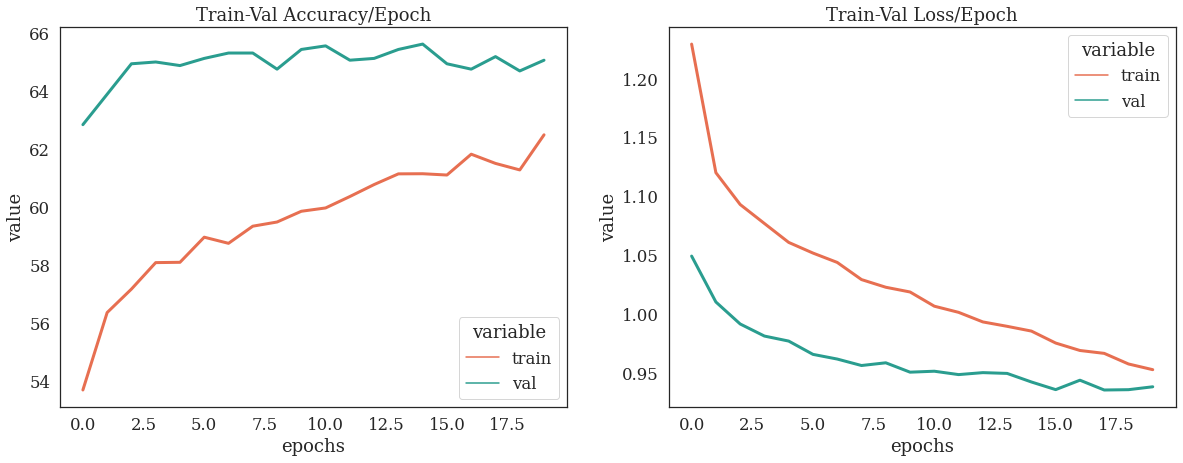

In [90]:
# Create dataframes
train_val_acc_df = pd.DataFrame.from_dict(accuracy_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
train_val_loss_df = pd.DataFrame.from_dict(loss_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
# Plot the dataframes
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,7))
sns.lineplot(data=train_val_acc_df, x = "epochs", y="value", hue="variable",
             ax=axes[0],palette = ['#e76f51','#2a9d8f'],linewidth = 3).set_title('Train-Val Accuracy/Epoch')
sns.lineplot(data=train_val_loss_df, x = "epochs", y="value", hue="variable",
             ax=axes[1],palette = ['#e76f51','#2a9d8f'],linewidth = 3).set_title('Train-Val Loss/Epoch')

Evalution on test set:

In [99]:
y_pred_list = []
with torch.no_grad():
    model.eval()
    for X_batch, _ in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        _, y_pred_tags = torch.max(y_test_pred, dim = 1)
        y_pred_list.append(y_pred_tags.cpu().numpy())
y_pred_list = [a.squeeze().tolist() for a in y_pred_list]

In [100]:
print("Test: Accuracy:",metrics.accuracy_score(y_test, y_pred_list))
print("Test: Precision:",metrics.precision_score(y_test, y_pred_list,average='weighted'))
print("Test: Recall:",metrics.recall_score(y_test, y_pred_list,average='weighted'))
print("Test: f1:",metrics.f1_score(y_test, y_pred_list,average='weighted'))

Test: Accuracy: 0.6346749226006192
Test: Precision: 0.6322698477605174
Test: Recall: 0.6346749226006192
Test: f1: 0.6302908773411193


Text(0.5, 1.0, 'Nueral Network')

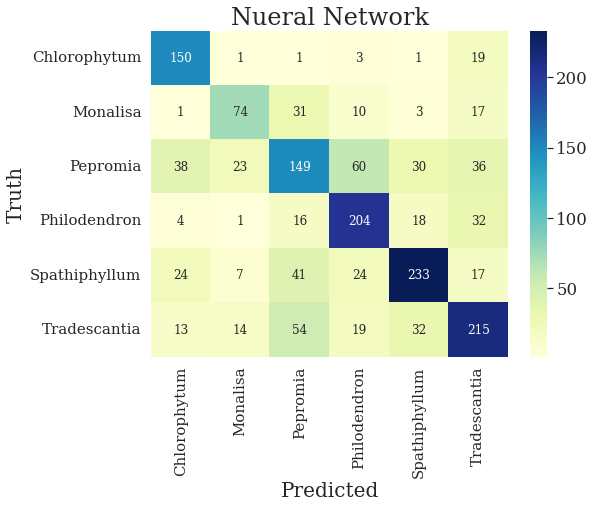

In [101]:
labels_dict = {v: k for k, v in labels_dict.items()}
map(lambda x: labels_dict[x], y_test_pred)

y_pred_arr = np.array(y_pred_list)
y_test_arr = np.array(y_test)

convert_dict = {    0:'Tradescantia',
 1:'Pepromia',
 2:'Spathiphyllum',
 3:'Monalisa',
 4:'Philodendron',
 5:'Chlorophytum'}

#  Convert values to species name
y_pred_labels = [convert_dict[pixel] for pixel in y_pred_arr]
y_test_labels = [convert_dict[pixel] for pixel in y_test_arr]

# labels to confiusion matrix:
unique_label = np.unique([y_test_labels, y_pred_labels])

cmtx = pd.DataFrame(
    confusion_matrix(y_test_labels, y_pred_labels, labels=unique_label), 
    index=[x for x in unique_label], 
    columns=[x for x in unique_label])
plt.figure(figsize = (8,6))
sns.heatmap(cmtx, annot=True, fmt='d',annot_kws={"size": 12},cmap="YlGnBu")
plt.xlabel('Predicted',fontsize = 20)
plt.ylabel('Truth', fontsize = 20)
plt.xticks(fontsize =15,rotation=90)
plt.yticks(fontsize =15,rotation=0)
plt.title('Nueral Network', fontsize = 24)

### **Summary Results**

In [102]:
f1 = f1_score(y_test_labels, y_pred_labels, average=None) #f1 score to each label
df_score['ANN'] = f1
df_score

,F1_Log_reg,F1_Score_RF,ANN
Chlorophytum,0.781491,0.806202,0.740741
Monalisa,0.512281,0.662420,0.578125
Peperomia,0.415698,0.600311,0.474522
Philodendron,0.474886,0.790861,0.685714
Spathiphyllum,0.663087,0.792109,0.702866
Tradescantia,0.581022,0.708207,0.629575


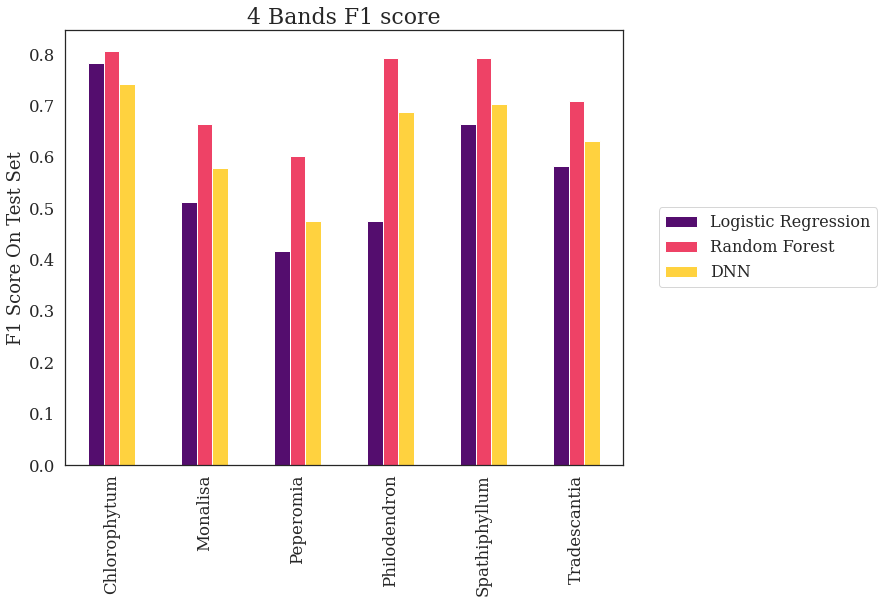

In [103]:
palette = ["#540d6e","#ee4266","#ffd23f"]
ax = df_score.plot.bar(figsize=(10,8),color=palette)
ax.set_ylabel("F1 Score On Test Set")
ax.set_title("4 Bands F1 score", fontsize=22)
plt.legend(['Logistic Regression', 'Random Forest', 'DNN'],loc=6, bbox_to_anchor=(1.05, 0.5),fontsize=16)

Save:

In [166]:
# torch.save(model.state_dict(), "/content/drive/MyDrive/Greenwall/Hyperspectral_data/All_data/Models/RGBN_ANN")

## **3. Apply on images**

I will build a function for each of the models so it b easy to load an image and get classification map

### Logistic Regression:

In [46]:
from PIL import Image, ImageEnhance
from keras.preprocessing.image import array_to_img
import pickle

def Logistic_Regression_Prediction(path_to_image, model, threshold,factor = 3):
  
  ####### 1. Load the image and prepare to model ######
  img = open_image(path)

  # Convert to df:
  wl = [397.32, 400.2, 403.09, 405.97, 408.85, 411.74, 414.63, 417.52, 420.4, 423.29, 426.19, 429.08, 431.97, 434.87, 437.76, 440.66, 443.56, 446.45, 449.35, 452.25, 455.16, 458.06, 460.96, 463.87, 466.77, 469.68, 472.59, 475.5, 478.41, 481.32, 484.23, 487.14, 490.06, 492.97, 495.89, 498.8, 501.72, 504.64, 507.56, 510.48, 513.4, 516.33, 519.25, 522.18, 525.1, 528.03, 530.96, 533.89, 536.82, 539.75, 542.68, 545.62, 548.55, 551.49, 554.43, 557.36, 560.3, 563.24, 566.18, 569.12, 572.07, 575.01, 577.96, 580.9, 583.85, 586.8, 589.75, 592.7, 595.65, 598.6, 601.55, 604.51, 607.46, 610.42, 613.38, 616.34, 619.3, 622.26, 625.22, 628.18, 631.15, 634.11, 637.08, 640.04, 643.01, 645.98, 648.95, 651.92, 654.89, 657.87, 660.84, 663.81, 666.79, 669.77, 672.75, 675.73, 678.71, 681.69, 684.67, 687.65, 690.64, 693.62, 696.61, 699.6, 702.58, 705.57, 708.57, 711.56, 714.55, 717.54, 720.54, 723.53, 726.53, 729.53, 732.53, 735.53, 738.53, 741.53, 744.53, 747.54, 750.54, 753.55, 756.56, 759.56, 762.57, 765.58, 768.6, 771.61, 774.62, 777.64, 780.65, 783.67, 786.68, 789.7, 792.72, 795.74, 798.77, 801.79, 804.81, 807.84, 810.86, 813.89, 816.92, 819.95, 822.98, 826.01, 829.04, 832.07, 835.11, 838.14, 841.18, 844.22, 847.25, 850.29, 853.33, 856.37, 859.42, 862.46, 865.5, 868.55, 871.6, 874.64, 877.69, 880.74, 883.79, 886.84, 889.9, 892.95, 896.01, 899.06, 902.12, 905.18, 908.24, 911.3, 914.36, 917.42, 920.48, 923.55, 926.61, 929.68, 932.74, 935.81, 938.88, 941.95, 945.02, 948.1, 951.17, 954.24, 957.32, 960.4, 963.47, 966.55, 969.63, 972.71, 975.79, 978.88, 981.96, 985.05, 988.13, 991.22, 994.31, 997.4, 1000.49, 1003.58]
  y = img[:,:,:].shape[0] # y axis
  x = img[:,:,:].shape[1] # x axis
  z = img[:,:,:].shape[2] # z axis (bands)
  a = img[:,:,:].reshape(x*y,z)  #Reshape to 2D array
  df = pd.DataFrame(a, columns=wl) #Convert to df

  # Keep with RGBN bands and standardization
  df = df[[414.63,551.49,681.69,732.53]]
  df = (df-df.mean())/df.std()
  
  ####### 2. Predict on the df, convert to numbers and reshape for image ######
  prediction = model.predict(df)

  labels_dict = {
    'Tradescantia':0,
    'Peperomia':1,
    'Spathiphyllum':2,
    'Monalisa':3,
    'Philodendron':4,
    'Chlorophytum':5
    }
  # df of prediction-> replace values to numbers by the dict -> convert to float array
  df_results = pd.DataFrame(prediction).replace(labels_dict).astype(float) 
  prediction = df_results.values
  # Reshape:
  prediction = prediction.reshape(img[:,:,:].shape[0],img[:,:,:].shape[1])

  ####### 3. Remove backround based on NDVI ######
  NDVI = ndvi(img[:,:,:], 97, 140) #create ndvi image
  # mask based on NDVI htreshold:
  mask_ndvi = np.where(NDVI > threshold , NDVI, 0) # Replace all values < thresh with 0
  mask_ndvi = np.where(mask_ndvi < threshold , mask_ndvi, 1) #Replace all values > thresh with 1
  # mask of ndvi on the original image
  prediction = np.where(mask_ndvi == 0, np.nan, prediction) # replace every pixel that the ndvi =0 nan

  ####### 4. Create bright RGB image ######
  #rgb image:
  red = img[:,:,97] #red band
  green = img[:,:,53] # green band
  blue = img[:,:,30] # blue band
  # 3 bands into new image
  RGB_Image = np.dstack([red,green,blue])# RGB  color composite

  #Bright:
  # COnvert array to image:
  RGB_Image = array_to_img(RGB_Image)

  #image brightness enhancer
  enhancer = ImageEnhance.Brightness(RGB_Image)
  factor = factor #brightens the image
  RGB_Image = enhancer.enhance(factor)

  return prediction,RGB_Image



Load image and predict:

In [47]:
# path to image
path = '/content/drive/MyDrive/Greenwall/HyperSpectral_images/merged/28_07_2022.hdr'
# load the model
with open("/content/drive/MyDrive/Greenwall/Hyperspectral_data/All_data/Models/RGBN_Logistic_Reg", "rb") as f:
  loaded_logr = pickle.load(f) #load the model
# Treshold
thresh = 0.3

# Apply the function:
logreg_map, RGB = Logistic_Regression_Prediction(path, loaded_logr, thresh, factor = 3)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  "X does not have valid feature names, but"


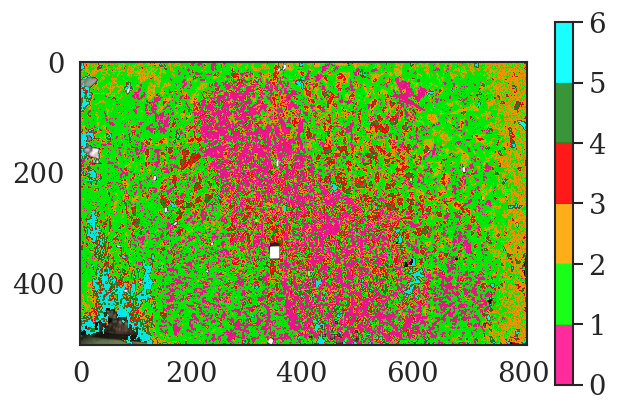

In [48]:
import matplotlib.colors
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("",["deeppink","lime","Orange","red","forestgreen","cyan"])
bounds=[0,1,2,3,4,5,6] #bounds of colorbar
norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)
# Graph
fig = plt.figure( dpi = 120)
ax  = plt.subplot(111)
plt.imshow(RGB) # RGB image 
plt.imshow(logreg_map,cmap = cmap,alpha=0.9,norm=norm) # prediction image
plt.colorbar()

### Random Forest

In [49]:
def RF_Prediction(path_to_image, model, threshold,factor = 3):
  
  ####### 1. Load the image and prepare to model ######
  img = open_image(path)

  # Convert to df:
  wl = [397.32, 400.2, 403.09, 405.97, 408.85, 411.74, 414.63, 417.52, 420.4, 423.29, 426.19, 429.08, 431.97, 434.87, 437.76, 440.66, 443.56, 446.45, 449.35, 452.25, 455.16, 458.06, 460.96, 463.87, 466.77, 469.68, 472.59, 475.5, 478.41, 481.32, 484.23, 487.14, 490.06, 492.97, 495.89, 498.8, 501.72, 504.64, 507.56, 510.48, 513.4, 516.33, 519.25, 522.18, 525.1, 528.03, 530.96, 533.89, 536.82, 539.75, 542.68, 545.62, 548.55, 551.49, 554.43, 557.36, 560.3, 563.24, 566.18, 569.12, 572.07, 575.01, 577.96, 580.9, 583.85, 586.8, 589.75, 592.7, 595.65, 598.6, 601.55, 604.51, 607.46, 610.42, 613.38, 616.34, 619.3, 622.26, 625.22, 628.18, 631.15, 634.11, 637.08, 640.04, 643.01, 645.98, 648.95, 651.92, 654.89, 657.87, 660.84, 663.81, 666.79, 669.77, 672.75, 675.73, 678.71, 681.69, 684.67, 687.65, 690.64, 693.62, 696.61, 699.6, 702.58, 705.57, 708.57, 711.56, 714.55, 717.54, 720.54, 723.53, 726.53, 729.53, 732.53, 735.53, 738.53, 741.53, 744.53, 747.54, 750.54, 753.55, 756.56, 759.56, 762.57, 765.58, 768.6, 771.61, 774.62, 777.64, 780.65, 783.67, 786.68, 789.7, 792.72, 795.74, 798.77, 801.79, 804.81, 807.84, 810.86, 813.89, 816.92, 819.95, 822.98, 826.01, 829.04, 832.07, 835.11, 838.14, 841.18, 844.22, 847.25, 850.29, 853.33, 856.37, 859.42, 862.46, 865.5, 868.55, 871.6, 874.64, 877.69, 880.74, 883.79, 886.84, 889.9, 892.95, 896.01, 899.06, 902.12, 905.18, 908.24, 911.3, 914.36, 917.42, 920.48, 923.55, 926.61, 929.68, 932.74, 935.81, 938.88, 941.95, 945.02, 948.1, 951.17, 954.24, 957.32, 960.4, 963.47, 966.55, 969.63, 972.71, 975.79, 978.88, 981.96, 985.05, 988.13, 991.22, 994.31, 997.4, 1000.49, 1003.58]
  y = img[:,:,:].shape[0] # y axis
  x = img[:,:,:].shape[1] # x axis
  z = img[:,:,:].shape[2] # z axis (bands)
  a = img[:,:,:].reshape(x*y,z)  #Reshape to 2D array
  df = pd.DataFrame(a, columns=wl) #Convert to df

  # Keep with RGBN bands and standardization
  df = df[[414.63,551.49,681.69,732.53]]
  
  ####### 2. Predict on the df, convert to numbers and reshape for image ######
  prediction = model.predict(df)

  labels_dict = {
    'Tradescantia':0,
    'Peperomia':1,
    'Spathiphyllum':2,
    'Monalisa':3,
    'Philodendron':4,
    'Chlorophytum':5
    }
  # df of prediction-> replace values to numbers by the dict -> convert to float array
  df_results = pd.DataFrame(prediction).replace(labels_dict).astype(float) 
  prediction = df_results.values
  # Reshape:
  prediction = prediction.reshape(img[:,:,:].shape[0],img[:,:,:].shape[1])

  ####### 3. Remove backround based on NDVI ######
  NDVI = ndvi(img[:,:,:], 97, 140) #create ndvi image
  # mask based on NDVI htreshold:
  mask_ndvi = np.where(NDVI > threshold , NDVI, 0) # Replace all values < thresh with 0
  mask_ndvi = np.where(mask_ndvi < threshold , mask_ndvi, 1) #Replace all values > thresh with 1
  # mask of ndvi on the original image
  prediction = np.where(mask_ndvi == 0, np.nan, prediction) # replace every pixel that the ndvi =0 nan

  ####### 4. Create bright RGB image ######
  #rgb image:
  red = img[:,:,97] #red band
  green = img[:,:,53] # green band
  blue = img[:,:,30] # blue band
  # 3 bands into new image
  RGB_Image = np.dstack([red,green,blue])# RGB  color composite

  #Bright:
  # COnvert array to image:
  RGB_Image = array_to_img(RGB_Image)

  #image brightness enhancer
  enhancer = ImageEnhance.Brightness(RGB_Image)
  factor = factor #brightens the image
  RGB_Image = enhancer.enhance(factor)

  return prediction,RGB_Image

In [50]:
# path to image
path = '/content/drive/MyDrive/Greenwall/HyperSpectral_images/merged/28_07_2022.hdr'
# load the model
with open("/content/drive/MyDrive/Greenwall/Hyperspectral_data/All_data/Models/RGBN_RF", "rb") as f:
  loaded_logr = pickle.load(f) #load the model
# Treshold
thresh = 0.3

# Apply the function:
RF_map, RGB = RF_Prediction(path, loaded_logr, thresh, factor = 3)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"


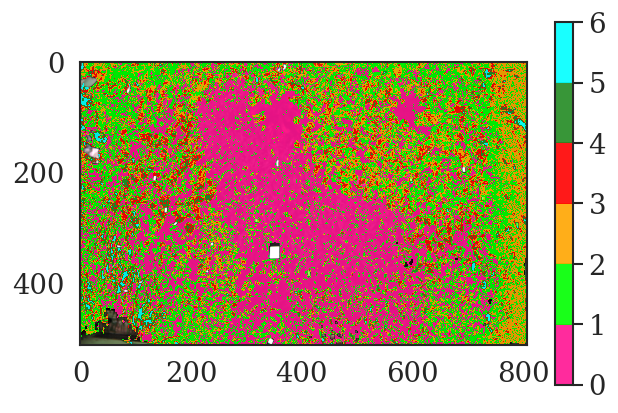

In [51]:
import matplotlib.colors
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("",["deeppink","lime","Orange","red","forestgreen","cyan"])
bounds=[0,1,2,3,4,5,6] #bounds of colorbar
norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)
# Graph
fig = plt.figure( dpi = 120)
ax  = plt.subplot(111)
plt.imshow(RGB) # RGB image 
plt.imshow(RF_map,cmap = cmap,alpha=0.9,norm=norm) # prediction image
plt.colorbar()

### Nueral Network

In [52]:
def ANN(path_to_image, model_path, threshold,factor = 3):
  
  ####### 1. Load the image and prepare to model ######
  img = open_image(path)

  # Convert to df:
  wl = [397.32, 400.2, 403.09, 405.97, 408.85, 411.74, 414.63, 417.52, 420.4, 423.29, 426.19, 429.08, 431.97, 434.87, 437.76, 440.66, 443.56, 446.45, 449.35, 452.25, 455.16, 458.06, 460.96, 463.87, 466.77, 469.68, 472.59, 475.5, 478.41, 481.32, 484.23, 487.14, 490.06, 492.97, 495.89, 498.8, 501.72, 504.64, 507.56, 510.48, 513.4, 516.33, 519.25, 522.18, 525.1, 528.03, 530.96, 533.89, 536.82, 539.75, 542.68, 545.62, 548.55, 551.49, 554.43, 557.36, 560.3, 563.24, 566.18, 569.12, 572.07, 575.01, 577.96, 580.9, 583.85, 586.8, 589.75, 592.7, 595.65, 598.6, 601.55, 604.51, 607.46, 610.42, 613.38, 616.34, 619.3, 622.26, 625.22, 628.18, 631.15, 634.11, 637.08, 640.04, 643.01, 645.98, 648.95, 651.92, 654.89, 657.87, 660.84, 663.81, 666.79, 669.77, 672.75, 675.73, 678.71, 681.69, 684.67, 687.65, 690.64, 693.62, 696.61, 699.6, 702.58, 705.57, 708.57, 711.56, 714.55, 717.54, 720.54, 723.53, 726.53, 729.53, 732.53, 735.53, 738.53, 741.53, 744.53, 747.54, 750.54, 753.55, 756.56, 759.56, 762.57, 765.58, 768.6, 771.61, 774.62, 777.64, 780.65, 783.67, 786.68, 789.7, 792.72, 795.74, 798.77, 801.79, 804.81, 807.84, 810.86, 813.89, 816.92, 819.95, 822.98, 826.01, 829.04, 832.07, 835.11, 838.14, 841.18, 844.22, 847.25, 850.29, 853.33, 856.37, 859.42, 862.46, 865.5, 868.55, 871.6, 874.64, 877.69, 880.74, 883.79, 886.84, 889.9, 892.95, 896.01, 899.06, 902.12, 905.18, 908.24, 911.3, 914.36, 917.42, 920.48, 923.55, 926.61, 929.68, 932.74, 935.81, 938.88, 941.95, 945.02, 948.1, 951.17, 954.24, 957.32, 960.4, 963.47, 966.55, 969.63, 972.71, 975.79, 978.88, 981.96, 985.05, 988.13, 991.22, 994.31, 997.4, 1000.49, 1003.58]
  y = img[:,:,:].shape[0] # y axis
  x = img[:,:,:].shape[1] # x axis
  z = img[:,:,:].shape[2] # z axis (bands)
  a = img[:,:,:].reshape(x*y,z)  #Reshape to 2D array
  df = pd.DataFrame(a, columns=wl) #Convert to df

  # Keep with RGBN bands and convert to array
  df = df[[414.63,551.49,681.69,732.53]]
  numpy_df = np.array(df)
  ####### 2. Restore the model and Predict ######
  class MulticlassClassification(nn.Module):
    def __init__(self, num_feature, num_class):
        super(MulticlassClassification, self).__init__()
        
        self.layer_1 = nn.Linear(num_feature, 56) #input = num_feature, output=512
        self.layer_2 = nn.Linear(56, 56)
        self.layer_3 = nn.Linear(56, 128)
        self.layer_out = nn.Linear(128, num_class) 
        
        self.relu = nn.ReLU() #Relu activation function
        self.dropout = nn.Dropout(p=0.0) #Dropout for avoid overfit
        self.batchnorm1 = nn.BatchNorm1d(56) # Batch normalization
        self.batchnorm2 = nn.BatchNorm1d(56)
        self.batchnorm3 = nn.BatchNorm1d(128)
        
    def forward(self, x):
        x = self.layer_1(x)
        x = self.batchnorm1(x)
        x = self.relu(x)
        
        x = self.layer_2(x)
        x = self.batchnorm2(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.layer_3(x)
        x = self.batchnorm3(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.layer_out(x)
        
        return x
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") #Run on GPU
  print(device) 
  num_features = len(df.columns) #how much features we have (bands)
  model = MulticlassClassification(num_feature = num_features , num_class=6) # hyperparameters
  model.to(device)
  Loss = nn.CrossEntropyLoss() #loss function 
  optimizer = optim.Adam(model.parameters(), lr=0.0005) #Optimization and learning rate for the learning.
  
  # Load the model
  model.load_state_dict(torch.load(model_path))
  model.eval()

  # predict:
  y_pred_list = []
  with torch.no_grad():
      model.eval()
      pred = numpy_df
      pred = torch.from_numpy(pred).float()
      pred = pred.to(device)
      y_test_pred = model(pred)
      _, y_pred_tags = torch.max(y_test_pred, dim = 1)
      y_pred_list.append(y_pred_tags.cpu().numpy())
  y_pred_list = [a.squeeze() for a in y_pred_list]

  prediction = np.array(y_pred_list).reshape(img[:,:,:].shape[0],img[:,:,:].shape[1])

  ####### 3. Remove backround based on NDVI ######
  NDVI = ndvi(img[:,:,:], 97, 140) #create ndvi image
  # mask based on NDVI htreshold:
  mask_ndvi = np.where(NDVI > threshold , NDVI, 0) # Replace all values < thresh with 0
  mask_ndvi = np.where(mask_ndvi < threshold , mask_ndvi, 1) #Replace all values > thresh with 1
  # mask of ndvi on the original image
  prediction = np.where(mask_ndvi == 0, np.nan, prediction) # replace every pixel that the ndvi =0 nan

  ####### 4. Create bright RGB image ######
  #rgb image:
  red = img[:,:,97] #red band
  green = img[:,:,53] # green band
  blue = img[:,:,30] # blue band
  # 3 bands into new image
  RGB_Image = np.dstack([red,green,blue])# RGB  color composite

  #Bright:
  # COnvert array to image:
  RGB_Image = array_to_img(RGB_Image)

  #image brightness enhancer
  enhancer = ImageEnhance.Brightness(RGB_Image)
  factor = factor #brightens the image
  RGB_Image = enhancer.enhance(factor)

  return prediction,RGB_Image

In [53]:
# path to image
image_path = '/content/drive/MyDrive/Greenwall/HyperSpectral_images/merged/28_07_2022.hdr'
# path to model
model_path = "/content/drive/MyDrive/Greenwall/Hyperspectral_data/All_data/Models/RGBN_ANN"
# Treshold
thresh = 0.3

# Apply the function:
DNN_map, RGB = ANN(image_path, model_path, thresh, factor = 3)

cuda:0


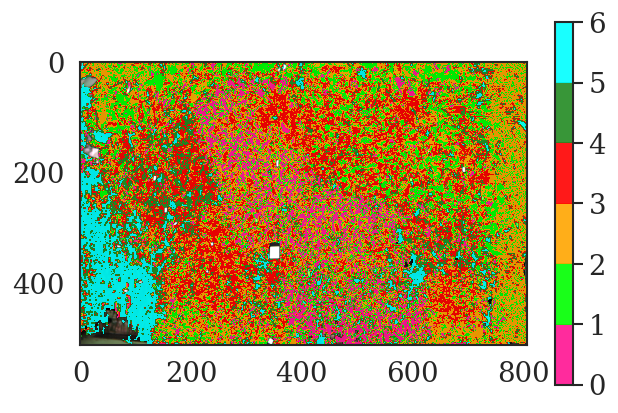

In [54]:
import matplotlib.colors
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("",["deeppink","lime","Orange","red","forestgreen","cyan"])
bounds=[0,1,2,3,4,5,6] #bounds of colorbar
norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)
# Graph
fig = plt.figure( dpi = 120)
ax  = plt.subplot(111)
plt.imshow(RGB) # RGB image 
plt.imshow(DNN_map,cmap = cmap,alpha=0.9,norm=norm) # prediction image
plt.colorbar()